## Laboratorium 7.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Jednak w praktyce czasami dysponujemy materiałem wideo, a więc sygnałami _trójwymiarowymi_, gdzie trzecim wymiarem jest czas. Oczywiście, można takie dane traktować jako po prostu sekwencję niezależnych obrazów - i wtedy działają wszystkie poznane dotychczas metody. Jednak dlaczego by nie wykorzystać tej dziedziny czasowej do przetwarzania sygnału? Intuicyjnie czujemy, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Najpowszechniejszą metodą do automatycznej detekcji ruchu jest metoda przepływu optycznego (ang. _optical flow_). Pominiemy w tej instrukcji matematyczne podstawy tej metody - te są wystarczająco dobrze wyłożone w [artykule z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), do którego lektury namawiam\*. Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

\* - Czytając, zwróć uwagę na podział na sekcje _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując translację pomiędzy jedną a drugą. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną i poprzednią.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu hardware'owego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [31]:
from typing import List

import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

In [65]:
def load_frames(video_name: str, start_frame: int, end_frame: int, verbose: bool = True) -> List[np.array]:
    """Loads given frames from the given video"""
    
    vid = cv2.VideoCapture(video_name)
    frames = []

    # Save frames
    for i in range(end_frame):
        flag, frame = vid.read()

        if i >= start_frame:
            frames.append(frame)

    # Show frames
    if verbose:
        fig, axes = plt.subplots(1, end_frame - start_frame, figsize=(30, 10))

        for ax, frame in zip(axes, frames):
            ax.imshow(frame)
            ax.axis("off")
    
    return frames


def farneback_benchmark(frames: List[np.array]):
    """Run farneback optical flow algorithm on pairs of frames"""
    
    fig, axes = plt.subplots(len(frames) - 1, 4, figsize=(30, 20))

    for i, (ax, frame1, frame2) in enumerate(zip(axes, frames, frames[1:])):
        frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(
            prev=frame1, 
            next=frame2, 
            flow=None, 
            pyr_scale=0.5, 
            levels=3,
            winsize=15,
            iterations=3,
            poly_n=5,
            poly_sigma=1.2,
            flags=0
        )
        
        ax[0].imshow(frame1)
        ax[1].imshow(frame2)
        ax[2].imshow(flow[..., 0])
        ax[3].imshow(flow[..., 1])

        ax[0].axis("off")
        ax[1].axis("off")

        if i == 0:
            ax[0].set_title("Previous frame")
            ax[1].set_title("Next frame")
            ax[2].set_title("x-axis direction")
            ax[3].set_title("y-axis direction")

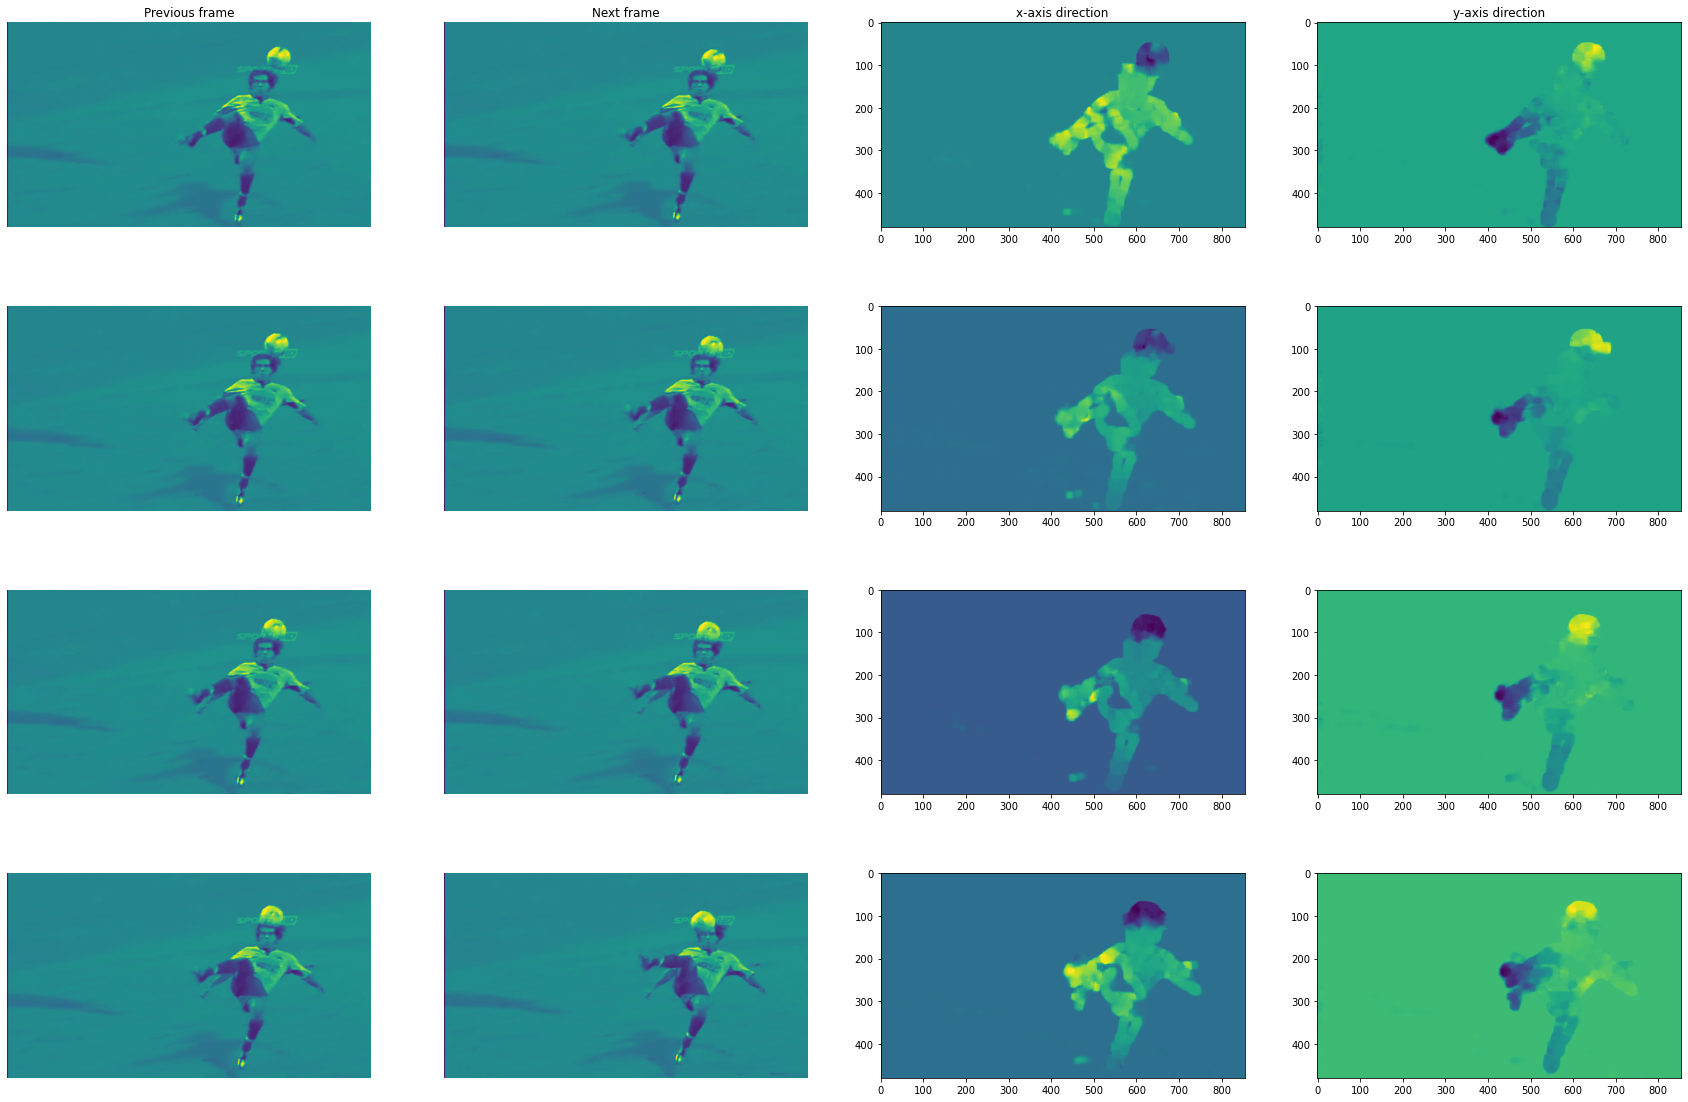

In [66]:
frames = load_frames("dane/kick.mp4", 20, 25, verbose=False)
farneback_benchmark(frames)

Po wartościach `optical flow` dla piłki widzimy, że porusza się ona w lewo po osi $X$ oraz w dół po osi $Y$ - co zgadza się z tym co dzieję się na filmie. Dla nogi dotrzegamy przeciwny ruch, który także się zgadza z tym co widzimy na filmie.

[h264 @ 0x55de7ca70680] mmco: unref short failure
[h264 @ 0x55de7ca70680] mmco: unref short failure


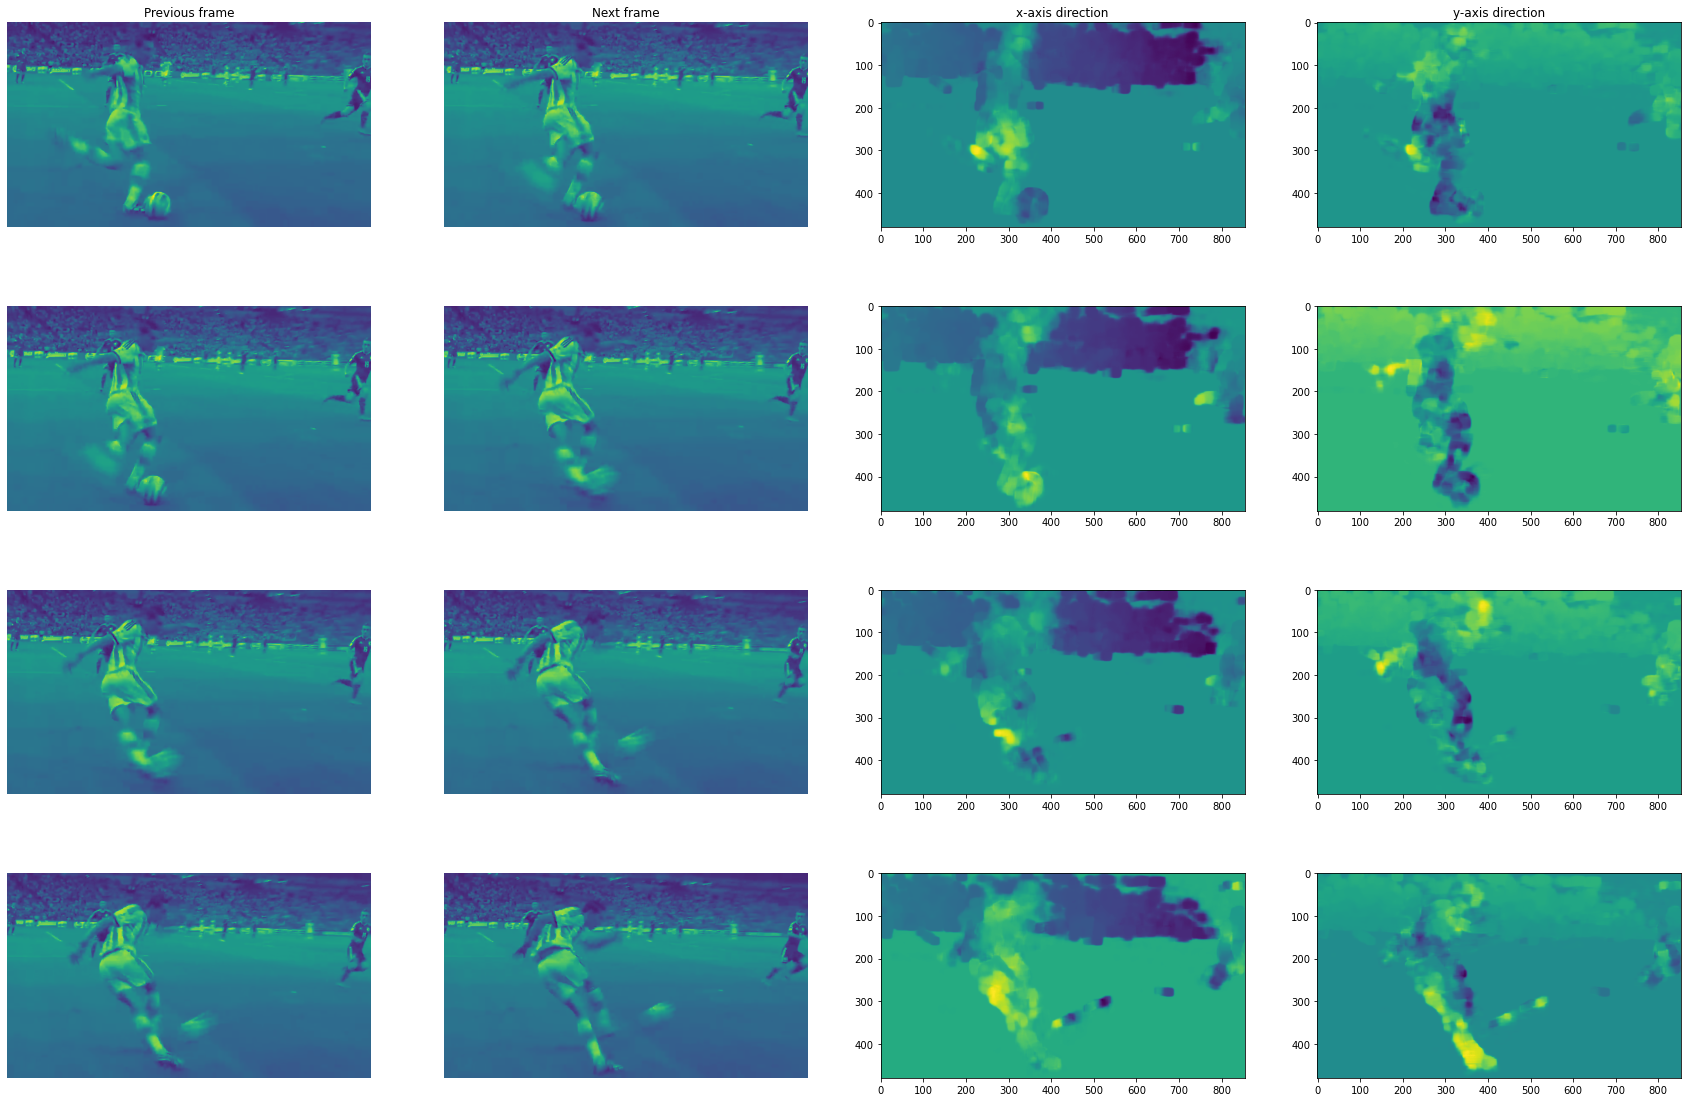

In [72]:
frames = load_frames("dane/back.mp4", 27, 32, verbose=False)
farneback_benchmark(frames)

Zauważamy, że piłka jest na tyle rozmazana na późniejszych zdjęciach, że trudno je wyłapać w ramach optical flow. Na wcześniejszych klatkach widzimy za to jak piłka najpierw porusza się w stronę lewego dolnego rogu obrazu, a następnie po kopnięciu w przeciwną stronę - widać to na wynikach optical flow.

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

In [79]:
def farneback_winsize_benchmark(frame1: np.array, frame2: np.array, winsizes: List[int]):
    """Run farneback optical flow winsize benchmark"""

    frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    # Plot images
    fig, axes = plt.subplots(1, 2, figsize=(30, 20))

    axes[0].imshow(frame1)
    axes[0].axis("off")

    axes[1].imshow(frame2)
    axes[1].axis("off")

    plt.show()

    # Plot winsize benchmark
    fig, axes = plt.subplots(2, 6, figsize=(30, 5))

    for ax, winsize in zip(axes.T, winsizes):
        flow = cv2.calcOpticalFlowFarneback(
            prev=frame1, 
            next=frame2, 
            flow=None, 
            pyr_scale=0.5, 
            levels=3,
            winsize=winsize,
            iterations=3,
            poly_n=5,
            poly_sigma=1.2,
            flags=0
        )
        
        ax[0].set_title(f"winsize={winsize}")
        ax[0].imshow(flow[..., 0])
        ax[1].imshow(flow[..., 1])

[h264 @ 0x55de7e72ef40] mmco: unref short failure
[h264 @ 0x55de7e72ef40] mmco: unref short failure


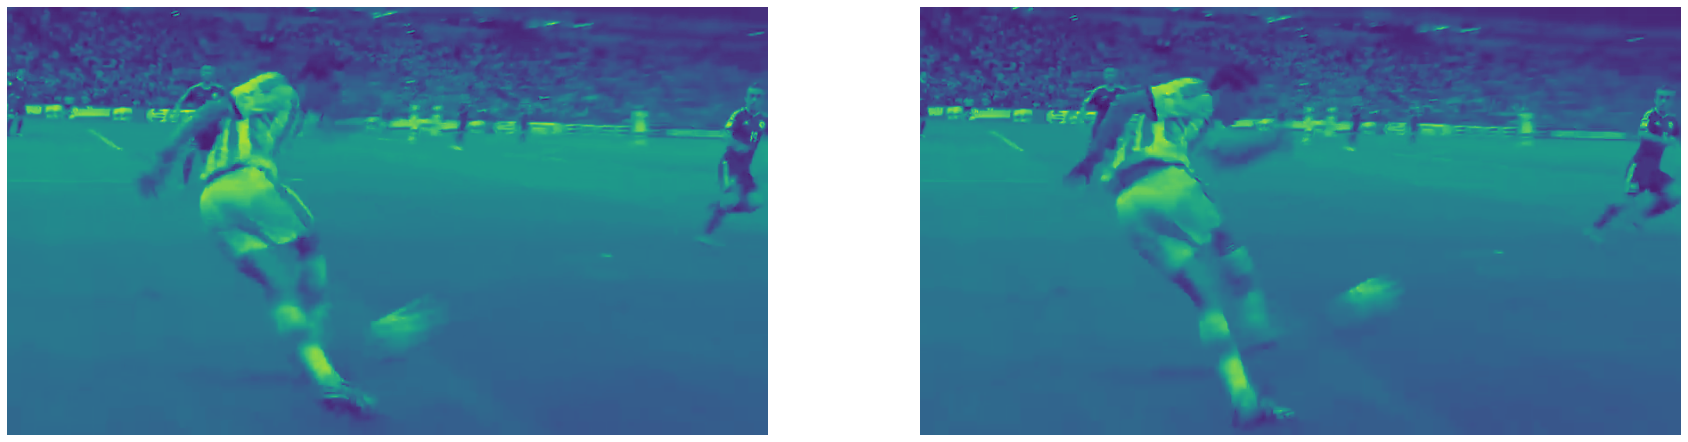

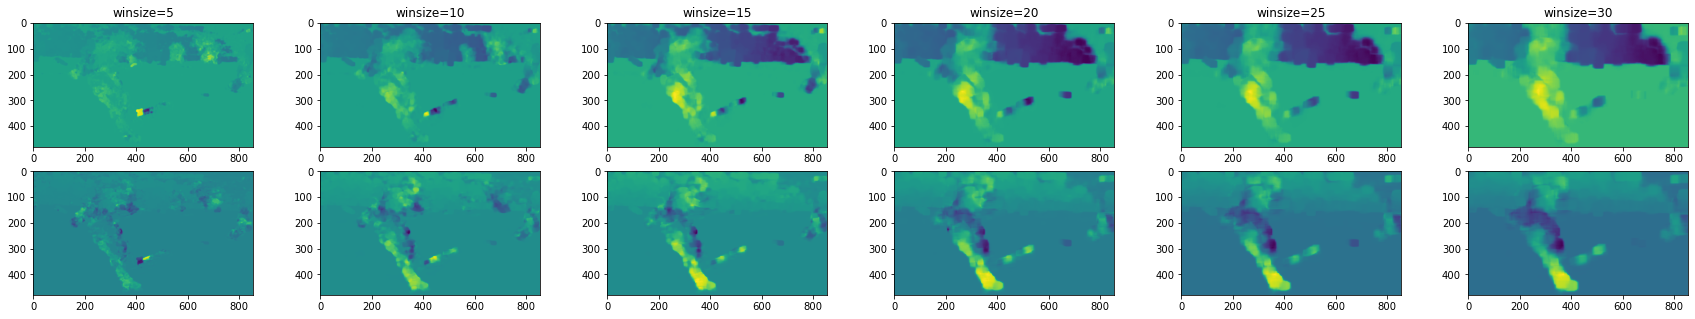

In [80]:
frame1, frame2 = load_frames("dane/back.mp4", 30, 32, verbose=False)
farneback_winsize_benchmark(frame1, frame2, [5, 10, 15, 20, 25, 30])

Komentarz 1:

Zwiększająć rozmiar okna detekcji zwiększa się zwracane rozmazanie pola ruchu. Algorytm jest także lepszy w wykrywaniu szybkich ruchów, gdy parametr `winsize` jest większy. Analizując wyniki zauważamy, że faktycznie pole ruchu przy większych wartościach parametru `winsize` jest bardziej rozmyte, jednak dokładność wykrycia szybkiego ruchu piłki nadal jest niskie.

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*W czym leży trudność? Co jest ograniczeniem metody?*

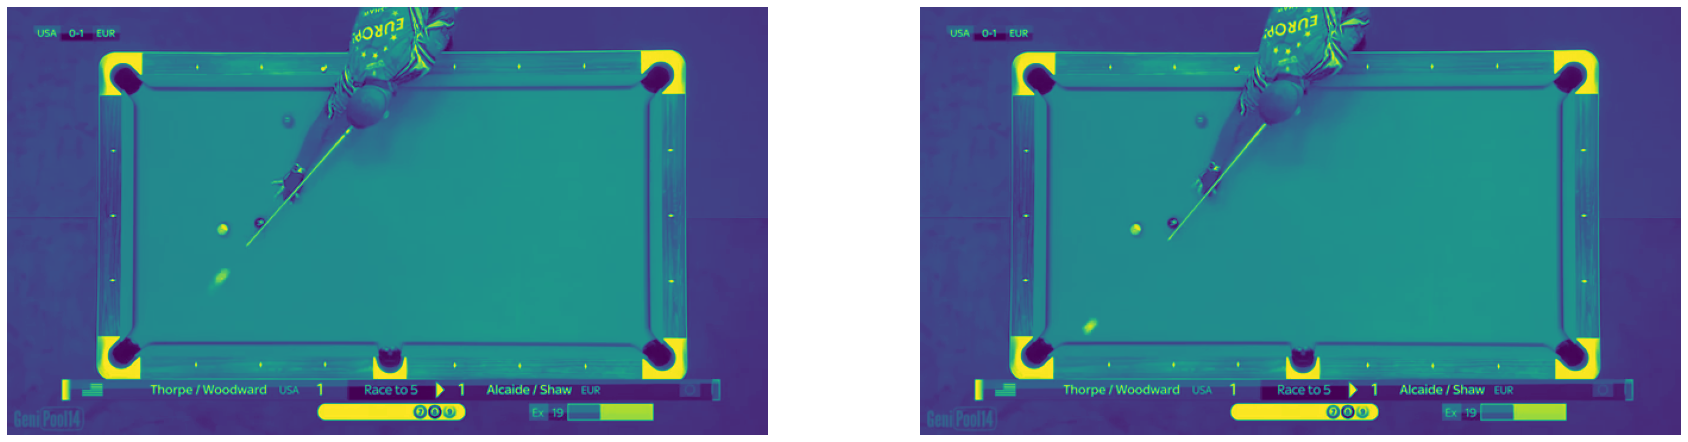

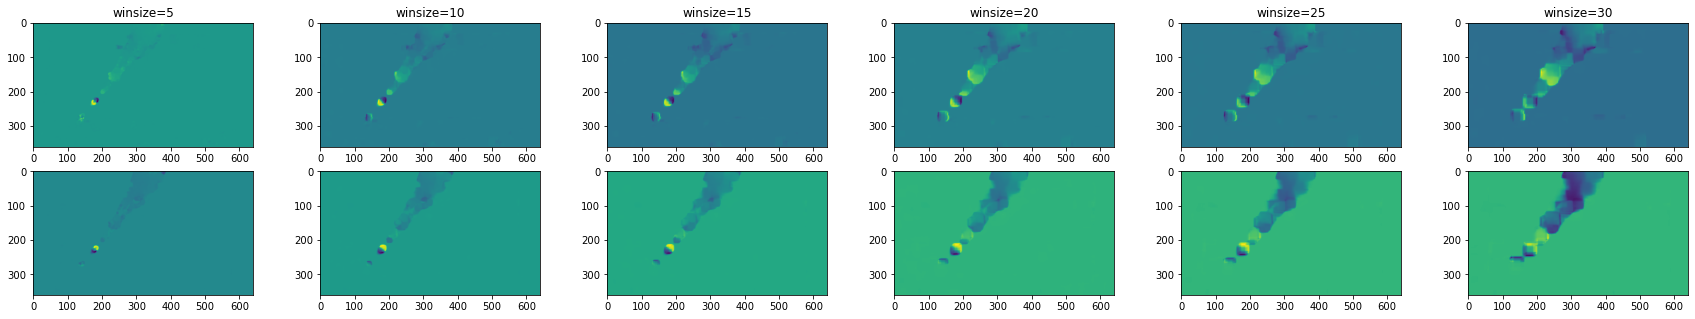

In [82]:
frame1, frame2 = load_frames("dane/shot.mp4", 21, 23, verbose=False)
farneback_winsize_benchmark(frame1, frame2, [5, 10, 15, 20, 25, 30])

Komentarz 2:

Trudnosć leży w rozmiarze poruszanego się obiektu, który jest stosunkowo mały w porównaniu do całego obrazu. Przy większym rozmazaniu obrazu, co potencjalnie powinno pomóc przy rozpoznawaniu szybkiego ruchu, mały obiekt jest na tyle rozmazany, że wykrycie jego ruchu jest problematycznie niemożliwe.

### Zadanie 3

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).

In [123]:
from skimage.morphology import remove_small_holes

def flow_segmentation(flow: np.array, threshold: float):
    """
    Run flow segmentation algorithm

    Threshold image based on motion magnitude, perform binary closing and extract largest connected component.
    """

    flow = (np.abs(flow) > threshold).astype(np.uint8) * 255

    kernel = np.ones((5, 5),np.uint8)
    flow = cv2.morphologyEx(flow, cv2.MORPH_CLOSE, kernel, iterations=5)

    num_labels, labels_im = cv2.connectedComponents(flow)
    values, counts = np.unique(labels_im, return_counts=True)

    largest_component = np.argmax(counts[1:]) + 1
    return remove_small_holes(labels_im == largest_component, area_threshold=2048)


def flow_segmentation_benchmark(frames: List[np.array]):
    """Run optical flow based segmentation"""
    
    fig, axes = plt.subplots(len(frames) - 1, 5, figsize=(30, 20))

    for i, (ax, frame1, frame2) in enumerate(zip(axes, frames, frames[1:])):
        frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(
            prev=frame1, 
            next=frame2, 
            flow=None, 
            pyr_scale=0.5, 
            levels=3,
            winsize=15,
            iterations=3,
            poly_n=5,
            poly_sigma=1.2,
            flags=0
        )
        
        ax[0].imshow(frame1)
        ax[1].imshow(frame2)
        ax[2].imshow(flow_segmentation(flow[..., 0], 0.4))
        ax[3].imshow(flow_segmentation(flow[..., 1], 0.4))
        ax[4].imshow(flow_segmentation((flow[..., 0] + flow[..., 1]) / 2, 0.4))

        ax[0].axis("off")
        ax[1].axis("off")

        if i == 0:
            ax[0].set_title("Previous frame")
            ax[1].set_title("Next frame")
            ax[2].set_title("x-axis abs threhsold seg")
            ax[3].set_title("y-axis abs threshold seg")
            ax[4].set_title("both-axis abs threshold seg")

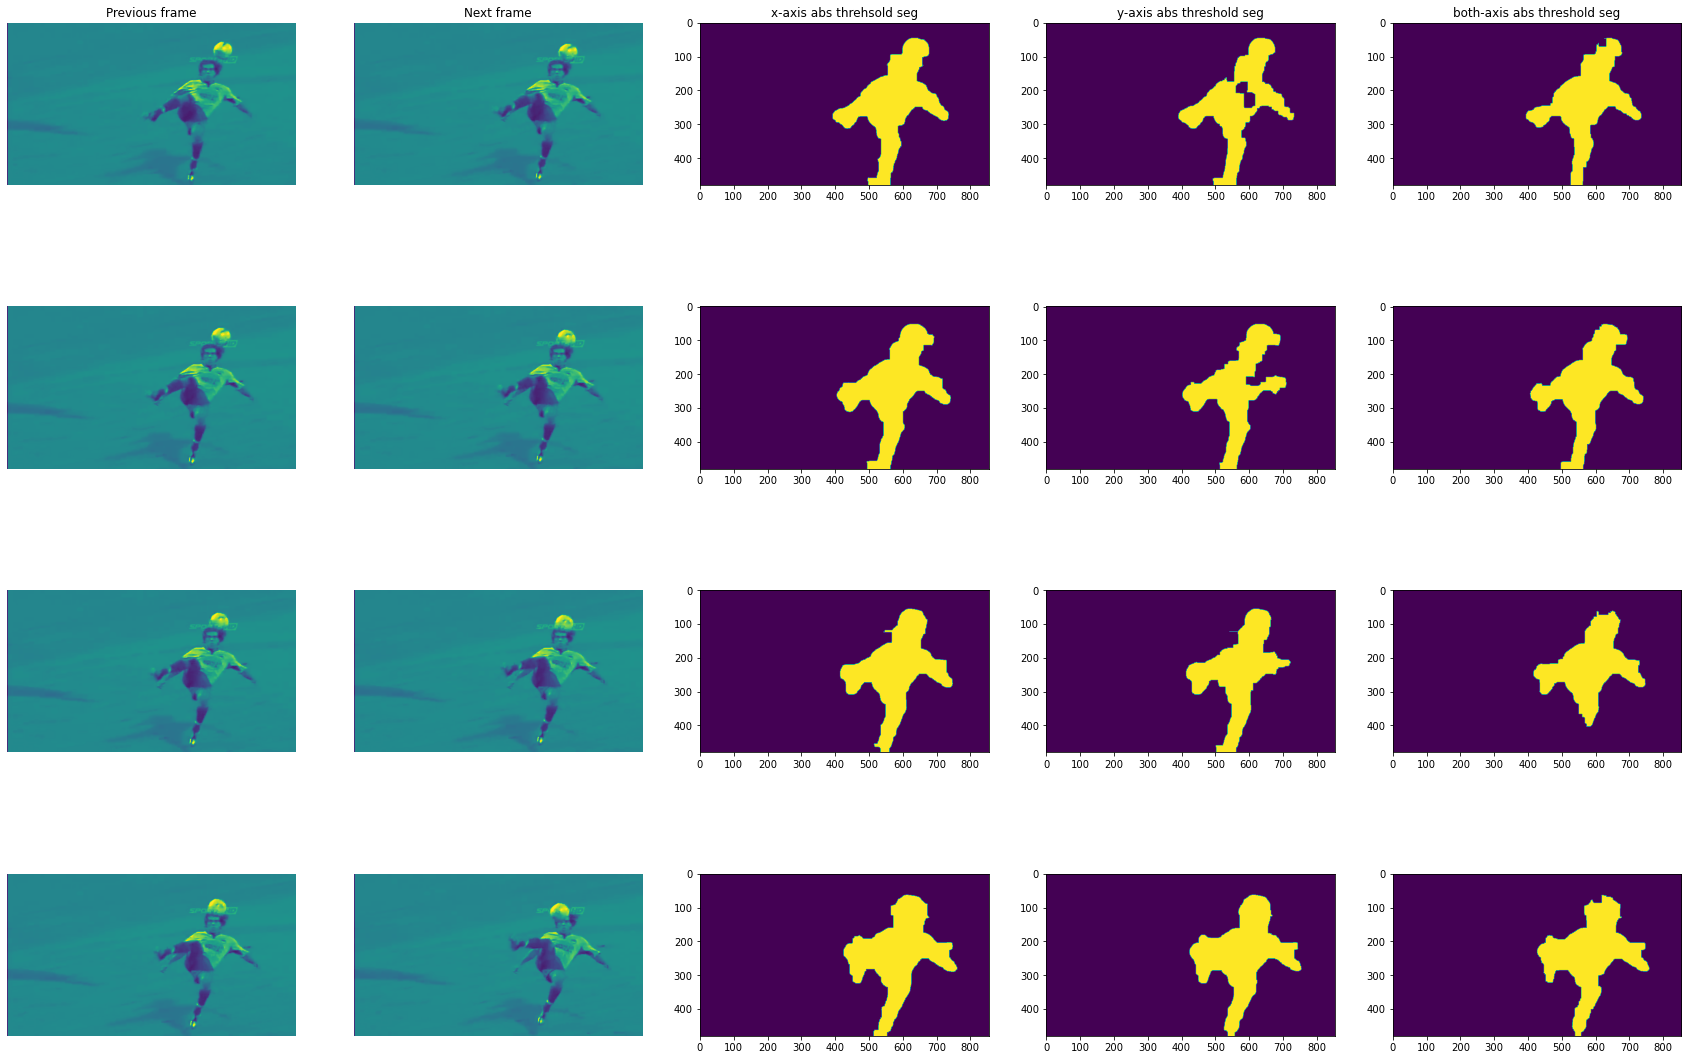

In [124]:
frames = load_frames("dane/kick.mp4", 20, 25, verbose=False)
flow_segmentation_benchmark(frames)

Wyniku algorytmu dla ruchu tylko po os $X$ zdają się być najstabilniejsze, lecz pewnie to kwestia konkretnego przykładu. Widzimy, że zaproponowany algorytm w miarę dobry sposób znajduje zawodnika na obrazie.